In [1]:
# FIRST WE'LL IMPORT THE SYSTEM LIBRARIES
import os
import itertools
import pathlib
from PIL import Image
import time
import shutil

In [2]:
# THEN IMPORT THE DATA HANDLING TOOLS
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [3]:
# THEN IMPORT DL LIBRARIES
import tensorflow as tf
from tensorflow import keras
#SEQUENTIAL CLASS FOR CREATING NEURAL NETWORK MODELS IN TENSORFLOW
#ALLOWS TO DEFINE A SEQUENTIAL STACK OF LAYERS
from tensorflow.keras.models import Sequential
#IMPORTED ADAMS AND ADAMAX OPTIMIZER
#ITERATIVELY ADJUST THE WEIGHTS OF NETWORK'S CONNECTIONS
#TO MINIMIZE A LOSS FUNCTION & IMPROVE MODEL'S PERFORMANCE
from tensorflow.keras.optimizers import Adam, Adamax
#IMAGE DATAGEN FOR AUGMENTING & PREPARING IMAGE DATA AS RANDOME FLIPS, ROTATIONS, SCALING
#PREVENTS OVERFITTING
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#IMPORTING ESSENTIAL LAYERS USED TO BUILD A CNN MODEL
#CONV2D LAYER PERFORMS CONVOLUTIONAL OPERATIONS, CORE BUILDING BLOCK OF CNN & EXTRACTS FEATURES FROM IMAGE
#MAXPOOLING2D PERFORMS DOWNSAMPLING, REDUCING DIMENSIONALITY OF DATA, CAPTURING SPATIAL INFO
#DENSE REPRESENTS FULLY CONNECTED LAYER USED IN FINAL STAGES OF MODEL FOR CLASSIFICATION OR REGRESSION TASKS
#FLATTEN FLATTENS MULTI-DIMENSIONAL OUTPUT OF CONVO LAYERS INTO A SINGLE VECTOR FOR FEEDING

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
#DROPOUT LAYER RANDOMLY DROPS CERTAIN PERCENTAGE OF NEURONS DURING TRAINING TO PREVENT OVERFITTING
#ACTIVATION LAYER APPLIES ACTIVATION FUNCTION (LIKE RELU) FOR NON-LINEARITY INTO NETWORK
#BATCHNORMALIZATION NORMALIZES ACTIVATIONS OF PREVIOUS LAYER, IMPROVING TRAINING SPEED & STABILITY
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout
#REGULARIZERS PENSLIZE MODEL FOR OVERLY COMPLEX WEIGHTS, HELPING TO PREVENT OVERFIITING
#REGULARIZERS FUNCTIONS LIKE L1 AND L2 REGULARIZATION
from tensorflow.keras import regularizers
#IGNORE WARNINGS
import warnings
warnings.filterwarnings("ignore")
print ('modules loaded')

modules loaded


In [4]:
test_file = 'C:\\Users\\KIIT\\Downloads\\Testing'
labels = []
#EMPLTY LIST LABELS TO STORE LABELS
filepaths = []
#CREATES ANOTHER EMPTY LIST, TO STORE COMPLETE FILE PATHS
folds = os.listdir(test_file)
#OS LIBRARY HAS ALREADY BEEN IMPORTED
#os.listdir(test_file) FUNCTION CALL RETRIEVES A LIST OF FILENEAMES AND SUBDIRECTORY NAMES WITHIN DIRECTORY
#RESULT OF THIS FUNCTION CALL IS STORED IN VARIABLE FOLDS

In [5]:
#ITERATE OVER EACH ELEMENT IN FOLD LIST
for fold in folds:
    #os.path.join FUNC FROM OS LIBRARY, IT COMBINES BASE PATH(test_file) WITH CURRENT FOLDER NAME (fold) & CREATES COMPLETE PATH TO CURRENT SUBFOLDER
    #RESULT STORED IN VARIABLE FOLDPATH
    foldpath = os.path.join(test_file, fold)
    #os.listdir WITH FOLDPATH
    filelist = os.listdir(foldpath)
    #STARTS ANOTHER NESTED FOR LOOP THAT ITERATES OVER EACH ELEMENT IN FILELIST
    for file in filelist:
        #COMBINES SUBFOLDER (FOLDPATH) WITH FILENAME (FILE)
        filepath = os.path.join(foldpath, file)
        #APPEND FILEPATH TO FILEPATHS LIST WITHIN TESTING DIRECTORY
        filepaths.append(filepath)
        #APPENDS CURRENT FOLDER NAME (FOLD) TO LABELS LIST
        labels.append(fold)
#FILESERIES CREATED  FROM FILEPATHS LIST, HOLD FILEPATHS AS PANDAS SERIES
FileSeries = pd.Series(filepaths, name = 'filepaths')
#LABELSERIES CREATED FROM LABELS LIST, HOLD LABELS AS PANDAS SERIES
LabelSeries = pd.Series(labels, name = 'labels')
#CONCATENATE THESE 2 SERIES INTO SINGLE DATAFRAME DT
#AXIS ARG SPECIFIES IT TO HAPPEN IN COLUMNS
dt = pd.concat([FileSeries, LabelSeries], axis = 'columns')
dt


,filepaths,labels
0,C:\Users\KIIT\Downloads\Testing\glioma\Te-glTr...,glioma
1,C:\Users\KIIT\Downloads\Testing\glioma\Te-glTr...,glioma
2,C:\Users\KIIT\Downloads\Testing\glioma\Te-glTr...,glioma
3,C:\Users\KIIT\Downloads\Testing\glioma\Te-glTr...,glioma
4,C:\Users\KIIT\Downloads\Testing\glioma\Te-glTr...,glioma
...,...,...
1306,C:\Users\KIIT\Downloads\Testing\pituitary\Te-p...,pituitary
1307,C:\Users\KIIT\Downloads\Testing\pituitary\Te-p...,pituitary
1308,C:\Users\KIIT\Downloads\Testing\pituitary\Te-p...,pituitary
1309,C:\Users\KIIT\Downloads\Testing\pituitary\Te-p...,pituitary


In [6]:
train_file = 'C:\\Users\\KIIT\\Downloads\\Training'
filepaths = []
labels = []

folds = os.listdir(train_file)
for fold in folds:
    foldpath = os.path.join(train_file, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
FileSeries = pd.Series(filepaths, name= 'filepaths')
LabelSeries = pd.Series(labels, name='labels')
data = pd.concat([FileSeries, LabelSeries], axis= 1)
data 

,filepaths,labels
0,C:\Users\KIIT\Downloads\Training\glioma\Tr-glT...,glioma
1,C:\Users\KIIT\Downloads\Training\glioma\Tr-glT...,glioma
2,C:\Users\KIIT\Downloads\Training\glioma\Tr-glT...,glioma
3,C:\Users\KIIT\Downloads\Training\glioma\Tr-glT...,glioma
4,C:\Users\KIIT\Downloads\Training\glioma\Tr-glT...,glioma
...,...,...
5707,C:\Users\KIIT\Downloads\Training\pituitary\Tr-...,pituitary
5708,C:\Users\KIIT\Downloads\Training\pituitary\Tr-...,pituitary
5709,C:\Users\KIIT\Downloads\Training\pituitary\Tr-...,pituitary
5710,C:\Users\KIIT\Downloads\Training\pituitary\Tr-...,pituitary


In [7]:
#VALID DATAFRAME WILL CONTAIN A PORTION OF DATA, WILL HAVE SAME STRUCTURE AS ORIGINAL DATAFRAME dt
#TESTING DATAFRAME WILL CONTAIN REMAINING PORTION OF DATA
#DT IS DATAFRAME CREATED CONTAINING FILPATHS & LABELS
#TRAIN SIZE - 0.5; ITS SET TO 0.5, WHICH MEANS 50% OF DATA WILL ALLOCATED TO TRAINING SET. REMAINING 50% WILL BE USED FOR TESTING SET
#SHUFFLE THE DATA BEFORE SPLITTING TO ENSURE TRAINING & TESTING REPRESENT A GOOD CROSS-SECTION & REDUCCE BIAS
#SET A SEED FOR RANDOM NUMBER GENERATOR USED FOR SHUFFLING DATA
#SETTING A SEED ENSURES WE GET SAME SPLIT 
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)

In [8]:
#ASSIGNS VALUE 16 TO BATCH SIZE, USED TO DEFINE NO. OF IMAGES PROCESSED DURING TRAINING & VALIDATION
batch_size=16
#CREATES A TUPLE CONTAINING HEIGHT N WIDTH IN PIXELS
image_size = (224,224)
#ASSIGNS YOUR IMAGE TO HAVE 3 COLOR CHANNELS (RGB)
channels = 3 
#COMBINES IMAGE HEIGHT, WIDTH, & NO. OF CHANNELS INTO A SINGLE TUBLE
image_shape=(image_size[0],image_size[1],channels)  #224*224*3
#CREATES AN INSTANCE AND ASSIGNS IT TO tr_gen; USED FOR DATA AUGMENTATION & PREPROCESSING DURING TRAINING
tr_gen = ImageDataGenerator()
#CREATES SEPARATE INSTANCE FOR PREPROCESSING TESTING DATA WITHOUT AUGMENTATION
ts_gen = ImageDataGenerator()

In [9]:
#GENERATORS ACT AS PIPELINES TO AUTOMATICALLY LOAD, PREPROCESS, AND AUGMENT YOUR IMAGES BASED ON PARAMETERS
train_gen = tr_gen.flow_from_dataframe( data, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= image_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


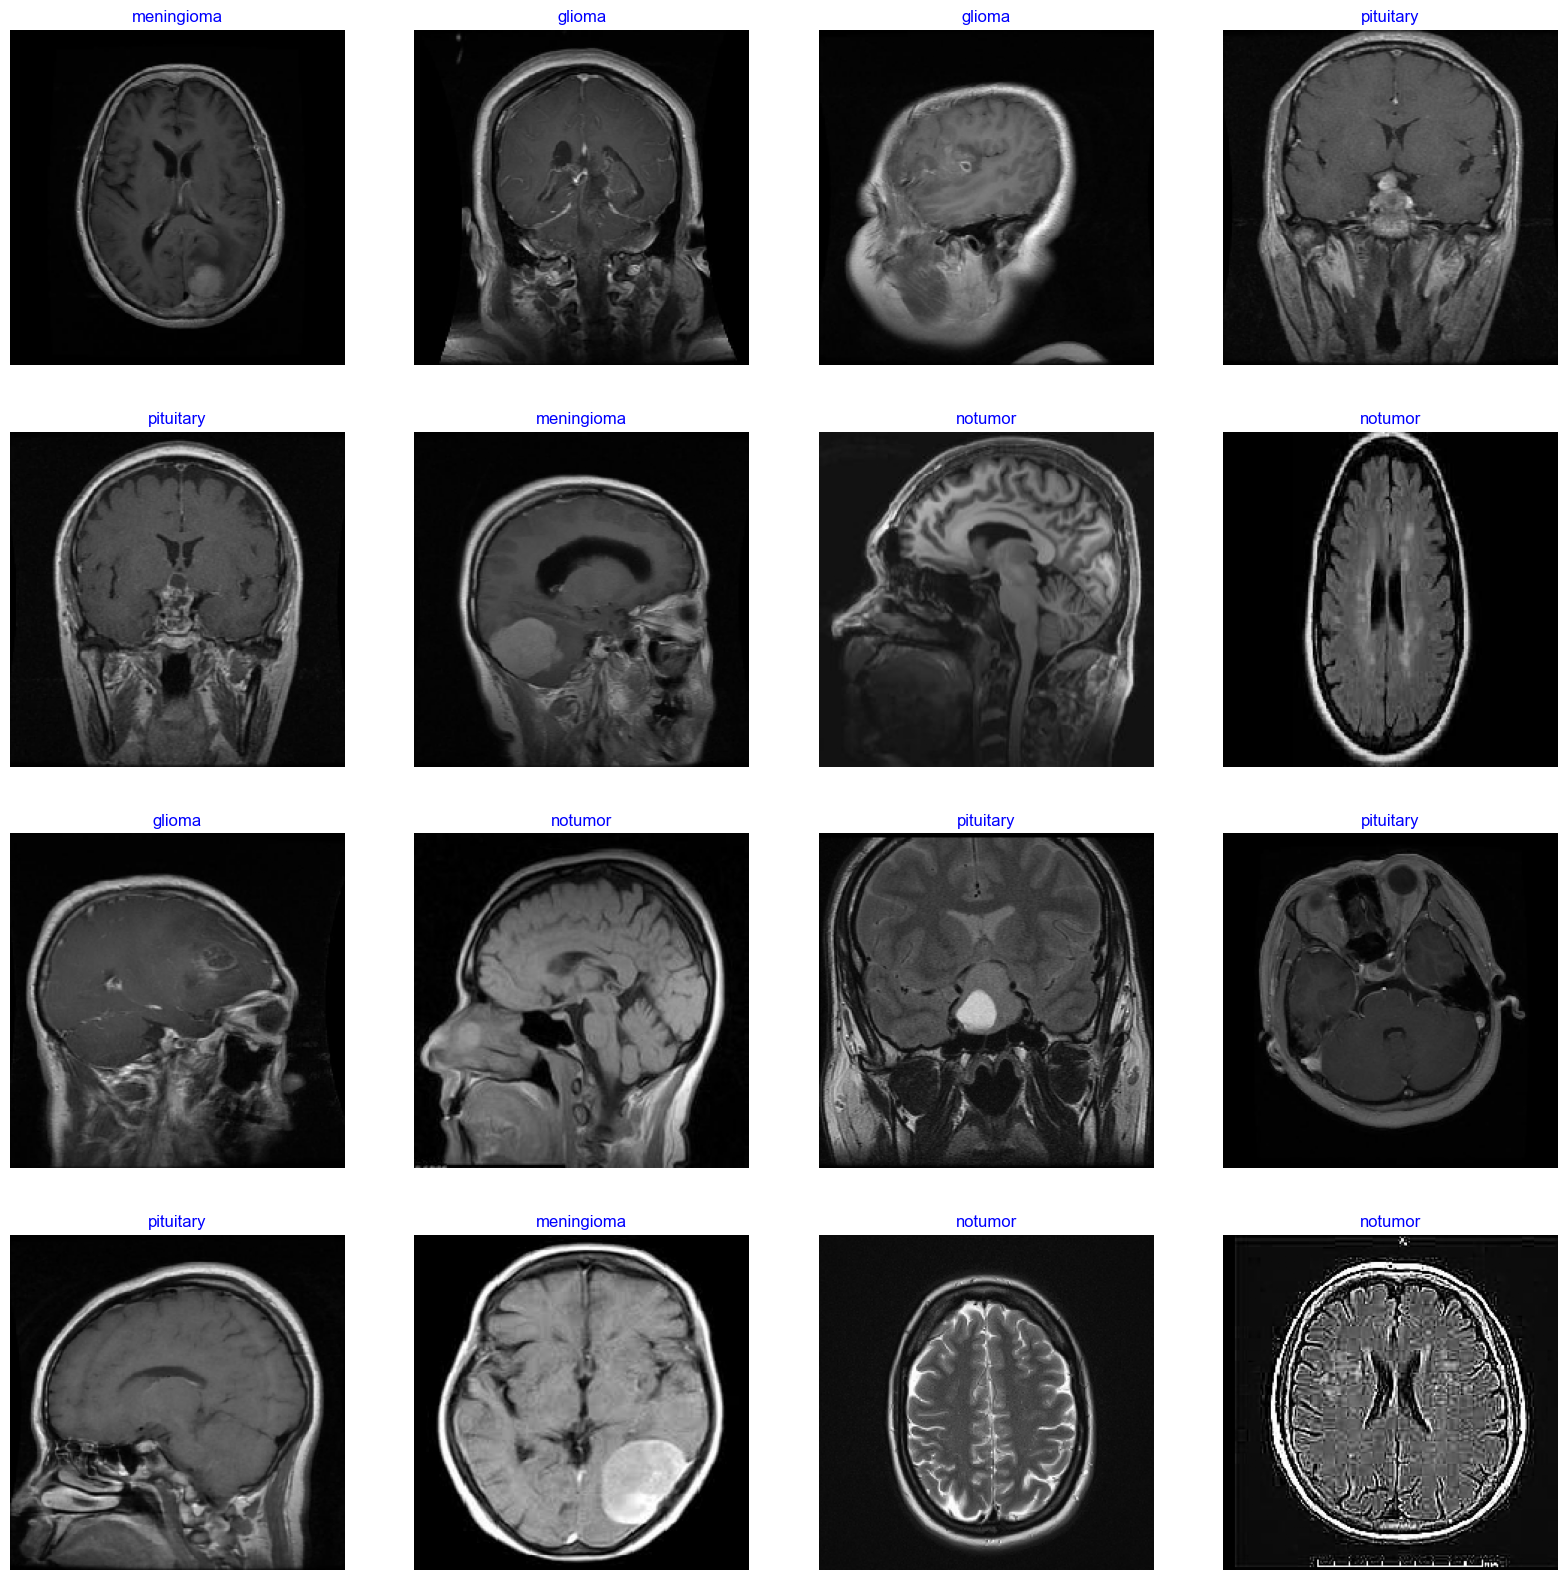

In [10]:
#RETREIVES DICTIONARY NAMES class_indices FROM train_gen (TRAINING DATA GENERATOR)
#WHICH MAPS CLASS LABELS TO CORRESPONDING INTEGER INDICES USED FOR ONE-HOT ENCODING
gen_dictionary = train_gen.class_indices
#LINE CREATES LIST NAMED classes; LIST FUNC CONVERT THE KEYS OF DICTIONARY INTO LIST
classes = list(gen_dictionary.keys())
#USES NEXT FUNC TO RETRIEVE BATCH OF DATA FROM train_gen (TRAINING DATA GENERATOR)
#BY CALLING NEXT ON THIS GENERATOR, YOU'RE ESSENTIALLY FETCHING NEXT BATCHOF IMAGES & LABELS
#IMAGES & LABELS WILL BE A NUMPY ARRAY
images,labels = next(train_gen)
#THE FOLLOWING LINE CREATES MATPLOTLIB FIGURE OBJECT
#plt.figure FUNC USED TO CREATE NEW FIG WINDOW FOR PLOTTING
#figsize ARG SETS WIGTH & HEIGHT OF FIGURE WINDOW IN INCHES; SET TO LARGE SIZE OF (20,20) INCHES
plt.figure(figsize = (20,20))

#ITERATES 16 TIMES; CREATES A SUBPLOT FROM MATPLOTLIB
#ARGUMENTS SPECIFY A GRID LAYOUT OF 4 ROWS & 4 COLUMNS
#i+1 ENSURES SUBPLOTS ARE FILLED IN ROW-MAJOR ORDER
for i in range(16):
    plt.subplot(4,4,i+1)
    #i-th IMAGE RETRIEVED FROM IMAGES ARRAY & PERFORMS NORMALIZATION
    #IMAGE DATA STORED AS INT VALUE BWTN 0 AND 255
    #RESULTANT IMAGE STORED IN IMAGE VARIABLE
    image = images[i]/255
    #DISPLAYS NORMALIZED IMAGE (image) ON CURRENT SUBPLOT
    plt.imshow(image)
    #FIND INDEX OF MAXIMUM VALUE, WHICH CORRESPONDS TO THE PREDICTED CLASS
    #INDEX OF PREDICTED CLASS IS STORED IN INDEX VARIABLE
    index = np.argmax(labels[i])
    #RETRIEVES ACTUAL CLASS LABEL NAME CORRESPONDING TO PREDICTED CLASS INDEX
    #USES classes LIST & ACCESSES ELEMENT AT INDEX
    class_name= classes[index]
    #SET TITLE OF CURRENT SUBPLOT USING plt.title FUNC
    #SET TO class_name WITH BLUE COLOR AND FONT SIZE TO 12
    plt.title(class_name,color='blue',fontsize=12)
    #HIDE AXIS LABELS & TICKS OF CURRENT SUBPLOT; 
    plt.axis('off')
#AFTER LOOP ENDS, LINE DISPLAYS ENTIRE FIG WINDOW CONTAINING GRID OF IMAGES & THEIR PREDICTED CLASS LABELS USING plt.show
plt.show();

In [11]:
#RETRIEVES NO. OF CLASSES  FROM TRAINING DATA GENERATOR TO DEFINE OUTPUT LAYER OF IMAGE CLASSIFICATION MODEL
image_size = (224, 224)
channels = 3
image_shape = (image_size[0], image_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [12]:
#DEFINES A CNN USING TENSORFLOW LIBRARY
#tf.keras.applications.VGG16 IMPORTS VGG16 ARCHITECTURE; IT IS A POPULAR PRE-TRAINED CNN MODEL THAT HAS BEEN TRAINED ON MASSIVE IMAGE DATASET (ImageNet)
#include_top=False ARG SPECIFIES NOT TO INCLUDE TOP (CLASSIFICATION) LAYERS OF MODEL
#weights="imagenet" LOADS PRE-TRAINED WEIGHTS FROM ImageNet DATASET INTO VGG16 MODEL, WEIGHTS CAPTURE VALUABLE IMAGE FEATURES LEARNED FROM LARGE DATASET
#input_shape=image_shape DEFINES EXPECTED INPUT SHAPE FOR MODEL
#pooling_'max' SPECIFIES TYPE OF POOLING OPERATION TO USE AT END OF PRE-TRAINED VGG16 MODEL; SET TO 'max' FOR MAX POOLING
base_model = tf.keras.applications.VGG16(include_top= False, weights= "imagenet", input_shape= image_shape, pooling= 'max')
#DEFINES SEQUENTIAL MODEL TO BUILT CNN
model = Sequential([
    #REFERS TO PRE-TRAINED VGG16 ADDED AS FIRST LAYER IN SEQ MODEL
    base_model,
    #LAYER INTRODUCES DROPOUT WITH RATE OF 0.45; DROPOUT RANDOMLY DROPS CERTAIN PERCENTAGE OF NEURONS DURING TRAINING TO PREVENT OVERFITTING
    Dropout(rate= 0.45, seed= 123),
    #APPLIES BATCH NORM TO IMPROVE SPEED N STABILITY
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    #DENSE LAYER FULLY CONNECTED LAYER WITH 256 NEURONS
    #kernel_regularizer=regularizers.l2(0.016) APPLIES L2 REGULARIZATION TO KERNELS OF LAYER TO PREVENT OVERFITTING
    #activity_regularizer=regularizers.l1(0.006) APPLIES L1 REGULARIZATION TO ACTIVATIONS OF LAYERS TO PREVENT OVERFITTING
    #activation='relu' SPECIFIES ACTIVATION FUNCTION FOR LAYER WHICH IS SET TO 'relu' (RECTIFIES LINEAR UNIT)
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    #ACTIVATION FUNC SET TO SOFTMAX; SOFTMAX ACTIVATION USED FOR MULTICLASS CLASSIFICATION PROBLEMS AS IT OUTPUTS A PROBABILITY DISTRIBUTION FOR EACH CLASS
    Dense(class_count, activation= 'softmax')
])


#Adamax SPECIFIES OPTIMIZER USED FOR TRAINING; IT IS CHOSEN WITH LEARNING RATE OF 0.01
#OPTIMIZER DETERMINES HOW MODELS UPDATES ITS INTERNAL WEIGHTS BASED ON ERROR
#loss FUNC TO MEASURE MODEL'S PERFORMANCE DURING TRAINING; CATEGORICAL CROSS ENTROPY MEAURES DIFF BTWN PREDICTED PROBABILITY DISTRIBUTION (FROM SOFTMAX ACTV) AND LABELS
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
#PRINT SUMMARY OF MODEL ARCH, NO. OF LAYERS, SHAPES N TOTAL NO. OF PARAMETERS
model.summary()
Model: "sequential_1"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 14,849,092
Trainable params: 14,848,068
Non-trainable params: 1,024
________________________________________

In [ ]:
#EPOCH FOR SINGLE PASS THROUGH ENTIRE TRAINING DATASET
#MODEL WILL GO THROUGH TRAINING DATA 30 TIMES
epochs = 30
#VERBOSE = 1: CONTROLS VERBOSITY. SETTING IT TO 1 PROVIDES LIMITED OUTPUT AFTER EACH EPOCH, INCLUDING EPOCH NUMBER, LOSS VALUE, ACCURACY
#SETTING IT TO 2 PROVIDES MORE DETAILED OUTPUT
#SETTING IT TO 0 PROVIDES NO OUTPUT
history = model.fit(x = train_gen, epochs = epochs, verbose = 1, validation_data = valid_gen, shuffle = False)

Epoch 1/30
357/357 [==============================] - 5016s 14s/step - loss: 4.2176 - accuracy: 0.5881 - val_loss: 3.2488 - val_accuracy: 0.2977
Epoch 2/30
357/357 [==============================] - 5102s 14s/step - loss: 1.9116 - accuracy: 0.6891 - val_loss: 1.4988 - val_accuracy: 0.6992
Epoch 3/30
357/357 [==============================] - ETA: 0s - loss: 1.1531 - accuracy: 0.7477 

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'c', label= 'Training loss')
plt.plot(Epochs, val_loss, 'm', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'c', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'm', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout

In [ ]:
train_score = model.evaluate(train_gen ,  verbose = 1)
valid_score = model.evaluate(valid_gen ,  verbose = 1)
test_score = model.evaluate(test_gen ,  verbose = 1)

In [ ]:
#ACCURACY ON TRAINING DATA IS 99.6% AND ON TEST DATA IS
#USE TRAINED MODEL TO GENERATE PREDICTIONS ON TEST DATA
preds = model.predict(test_gen)
#np.argmax FINDS INDEX OF LARGEST ELEMENT ALONG GIVEN AXIS IN ARRAY
#axis = 1 SPECIFIES WE'RE FINDING MAX VAL ALONG FIRST AXIS, CONVERTS MODEL'S PROBABILITY INTO PREDICTED CLASS LABELS
y_pred = np.argmax(preds, axis = 1)

In [ ]:
#CREATE CONFUSION MATRIX TO EVALUATE PERFORMANCE ON TEST DATA
#RETRIEVES A DICT class_indices, MAPS INT LABELS
g_dict = test_gen.class_indices
#CREATES A LIST NAMED CLASSES, CONVERT KEYS FROM DICT INTO LIST; INT LABELS TO CLASSES
classes = list(g_dict.keys())
#CONFUSION MATRIX CREATED; TAKES 2 ARG
#COMPARES ACTUAL CLASS LABELS WITH PREDICTED CLASS LABELS FOR TEST DATA
#CORRECT CLASSIFICATION: HIGH VALUES ON DIAGONAL
cm = confusion_matrix(test_gen.classes, y_pred)
cm 

In [ ]:
#CREATE FIG WINDOW
#VISUALIZATION OF CONFUSION MATRIX USING MATPLOTLIB
plt.figure(figsize= (10, 10))
#DISPLAY DATA, SPECIFY RESAMPLING MATHOD USED TO DISPLAY IMAGE
#nearest ASSIGNS NEAREST COLOR FROM COLORMAP TO EACH PIXEL
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Reds)
plt.title('Confusion Matrix')
#DISPLAY MAPPING BTWN VALUES IN CONFUSION MATRIX & COLORS USED IN IMAGE PLOT; HELPS INTERPRET COLOR INTENSITY IN IMAGE
plt.colorbar()
#IMPROVE READABILITY, CREATE ARRAY OF EVENLY SPACED VAL WITHIN SPECIFIED RANGE (0 to len(classes)-1)
tick_marks = np.arange(len(classes))
#X-AXIS LABELS OF CM PLOT
#ROTATES AXIS TO 45% TO PREVENT OVERLAPPING OF LONG CLS NAMES
plt.xticks(tick_marks, classes, rotation= 45)
#Y-AXIS LABELS OF CM PLOT
plt.yticks(tick_marks, classes)
#DEFINES THRESHOLD VALUE, CALC MAX VALUE IN CM & DIVIDES IT BY 2, USED TO DETERMINE TEXT COLOR FOR ANNOTATIONS
thresh = cm.max() / 2.
#START ITERATING
#range(cm.shape[0]) CREATES SEQ OF NUMBERS FROM 0 TO NO. OF ROWS IN CM
#range(cm.shape[1]) CREATES SEQ OF NUMBERS FROM 0 TO NO. OF COLUMNS IN CONFUSION MATRIX MINUS 1
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
#HIGH VALUES: WHITE TEXT ON DARK BACKGROUND, LOW VALUES: BLACK TEXT ON LLIGHT BACKGROUND
#ADJUST SPACING BTWN PLOT ELEMENTS TO AVOID OVERLAPPING
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()